In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [2]:
class Layer:

    def __init__(self, num_neurons, num_arg, activate_fun):
        # normal distribution
        # self.weight_array = np.random.uniform(0, 1, (num_neurons, num_arg))
        # self.bias_array = np.random.uniform(0, 1, (num_neurons, 1))
        
        # He (Kaiming Initialization)
        self.weight_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, num_arg))
        self.bias_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, 1))
        self.activate_fun = activate_fun
        self.last_activation = None
        self.last_argument = None
        
        self.weight_momentum = np.zeros((num_neurons, num_arg))
        self.bias_momentum = np.zeros((num_neurons, 1))

        self.weight_rmsprop = np.zeros((num_neurons, num_arg))
        self.bias_rmsprop = np.zeros((num_neurons, 1))


    def forward(self, arguments_array):
        f = self.weight_array @ arguments_array + self.bias_array
        g = self.activate_fun(f)
        self.last_activation = g.copy()
        self.last_argument = arguments_array.copy()
        return g

class Network:

    def __init__(self, size_layers, size_input, activate_fun_array):
        self.size_layers = size_layers
        self.size_input = size_input

        num_arg = [size_input] + size_layers
        self.layers = [Layer(size_layers[i], num_arg[i], activate_fun_array[i]) for i in range(len(size_layers))]
        self.mse_list = []


    def forward(self, arguments_array):
        for layer in self.layers:
            arguments_array = layer.forward(arguments_array)
        return arguments_array


    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = (y_hat - y)
        dL_df = dL_dg
        dL_dw = dL_df @ self.layers[-1].last_argument.T
        dL_db = dL_df
        self.layers[-1].weight_array -= (params["eta"] * dL_dw / x.shape[1]).copy()
        self.layers[-1].bias_array -= ((params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
        dL_dg = self.layers[-1].weight_array.T @ dL_df
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * (layer.last_activation * (1 - layer.last_activation))
            dL_dw = dL_df @ layer.last_argument.T
            dL_db = dL_df
            layer.weight_array -= (params["eta"] * dL_dw / x.shape[1]).copy()
            layer.bias_array -= ((params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
            dL_dg = layer.weight_array.T @ dL_df
            
            
    def mini_batches(self, X, Y, batch_size):
        num_samples = X.shape[1]
        
        new_index = np.arange(num_samples)
        np.random.shuffle(new_index)
        X_shuffled = X[:, new_index]
        Y_shuffled = Y[:, new_index]
        
        for start_ind in range(0, num_samples, batch_size):
            end_ind = min(start_ind + batch_size, num_samples)
            yield X_shuffled[:, start_ind:end_ind], Y_shuffled[:, start_ind:end_ind]
        
    
    
    def train(self, X, Y, X_test, Y_test, epochs, params, batch_size):
        for epoch in range(epochs):
            for x_batch, y_batch in self.mini_batches(X, Y, batch_size):
                self.backprop(x_batch, y_batch, params)
                
            y_hat_ = self.forward(X_test)
            mse_test = np.mean((y_hat_ - Y_test) ** 2)
            y_hat_ = self.forward(X)
            mse = np.mean((y_hat_ - Y) ** 2)
            self.mse_list.append(mse)
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, MSE = {mse:.4f}, MSE test = {mse_test:.4f}")


    def visualise_weights(self):
        matrices = [self.layers[m].weight_array for m in range(len(self.layers))]
        total_width = sum([mat.shape[1] for mat in matrices]) * 2
        max_height = max([mat.shape[0] for mat in matrices]) * 2

        plt.figure(figsize=(total_width, max_height))

        for m, mat in enumerate(matrices):
            plt.subplot(1, len(matrices), m + 1)
            ax = sns.heatmap(mat, annot=True, cmap='viridis', square=True, cbar=False, annot_kws={"fontsize":18})
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.title(f'Layer {m + 1}')

        plt.tight_layout()
        plt.show()
    
    
    def visualise_as_strip(self, title):
        arrays = [self.layers[m].weight_array for m in range(len(self.layers))]
        flattened_array = np.concatenate([arr.flatten() for arr in arrays])
        plt.figure(figsize=(len(flattened_array), 5))
        ax = sns.heatmap(flattened_array.reshape(1, -1), annot=True, cmap='viridis', square=True, cbar=False)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.title(title)
        plt.show()


def sigmoid(v):
    v = v.astype(np.longdouble)
    # return np.exp(v) / (np.exp(v) + 1)
    return 1.0 / (1.0 + np.exp(-v))


def linear(v):
    v = v.astype(np.longdouble)
    return v


class Momentum_Network(Network):

    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = (y_hat - y)
        dL_df = dL_dg
        dL_dw = dL_df @ self.layers[-1].last_argument.T
        dL_db = dL_df
    
        self.layers[-1].weight_momentum = params["momentum"] * self.layers[-1].weight_momentum + params["eta"] * dL_dw / x.shape[1]
        self.layers[-1].bias_momentum = params["momentum"] * self.layers[-1].bias_momentum + (params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)
        self.layers[-1].weight_array -= self.layers[-1].weight_momentum
        self.layers[-1].bias_array -= self.layers[-1].bias_momentum
    
        dL_dg = self.layers[-1].weight_array.T @ dL_df
    
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * (layer.last_activation * (1 - layer.last_activation))
            dL_dw = dL_df @ layer.last_argument.T
            dL_db = dL_df
            layer.weight_momentum = params["momentum"] * layer.weight_momentum + params["eta"] * dL_dw / x.shape[1]
            layer.bias_momentum = params["momentum"] * layer.bias_momentum + (params["eta"] * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)
            layer.weight_array -= layer.weight_momentum
            layer.bias_array -= layer.bias_momentum
            dL_dg = layer.weight_array.T @ dL_df
            

class RMSProp_Network(Network):

    def backprop(self, x, y, params):
        y_hat = self.forward(x)
        dL_dg = (y_hat - y)
        dL_df = dL_dg
        dL_dw = (dL_df @ self.layers[-1].last_argument.T) / x.shape[1]
        dL_db = np.sum(dL_df, axis=1) / x.shape[1]
        self.layers[-1].weight_rmsprop = params["beta"] * self.layers[-1].weight_rmsprop + (1 - params["beta"]) * np.power(dL_dw, 2)
        self.layers[-1].bias_rmsprop = params["beta"] * self.layers[-1].bias_rmsprop + (1 - params["beta"]) * np.power(dL_db, 2)
        self.layers[-1].weight_array -= params["eta"] * dL_dw/(np.sqrt(self.layers[-1].weight_rmsprop + params["epsilon"]))
        self.layers[-1].bias_array -= (params["eta"] * dL_db/(np.sqrt(self.layers[-1].bias_rmsprop + params["epsilon"]))).reshape(-1, 1)
        dL_dg = self.layers[-1].weight_array.T @ dL_df
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * (layer.last_activation * (1 - layer.last_activation))
            dL_dw = (dL_df @ layer.last_argument.T) / x.shape[1]
            dL_db = (np.sum(dL_df, axis=1) / x.shape[1]).reshape(-1, 1)
            layer.weight_rmsprop = params["beta"] * layer.weight_rmsprop + (1 - params["beta"]) * np.power(dL_dw, 2)
            layer.bias_rmsprop = params["beta"] * layer.bias_rmsprop + (1 - params["beta"]) * np.power(dL_db, 2)
            layer.weight_array -= params["eta"] * dL_dw/(np.sqrt(layer.weight_rmsprop + params["epsilon"]))
            layer.bias_array -= (params["eta"] * dL_db/(np.sqrt(layer.bias_rmsprop + params["epsilon"]))).reshape(-1, 1)
            dL_dg = layer.weight_array.T @ dL_df
        
    

## Square large

In [3]:
ss_train = pd.read_csv('NN\\regression\\square-large-training.csv', dtype=np.longdouble)
ss_test = pd.read_csv('NN\\regression\\square-large-test.csv', dtype=np.longdouble)

In [4]:
X = ss_train['x'].values.reshape(1, -1)
y = ss_train['y'].values.reshape(1, -1)
X_test = ss_test['x'].values.reshape(1, -1)
y_test = ss_test['y'].values.reshape(1, -1)

In [5]:
layers = [50, 1]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]

params = {"eta": 0.001, "momentum": 0.9, "beta": 0.999, "epsilon": 10**(-8)}
N1 = RMSProp_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N1.train(X=X, Y=y, X_test=X_test, Y_test=y_test, epochs=25000, params=params, batch_size=32)
mse1 = N1.mse_list

N2 = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N2.train(X=X, Y=y, X_test=X_test, Y_test=y_test, epochs=25000, params=params, batch_size=32)
mse2 = N2.mse_list

print(f'MSE RMSProp = {mse1[-1]}, MSE2 Momentum = {mse2[-1]}')

Epoch 1/25000, MSE = 9239.4975, MSE test = 10541.8494
Epoch 101/25000, MSE = 4728.3997, MSE test = 9222.4758
Epoch 201/25000, MSE = 3512.4099, MSE test = 8178.4061
Epoch 301/25000, MSE = 2648.6473, MSE test = 7138.0629
Epoch 401/25000, MSE = 1988.1467, MSE test = 6168.6276
Epoch 501/25000, MSE = 1465.4337, MSE test = 5343.7640
Epoch 601/25000, MSE = 1045.8490, MSE test = 4610.3774
Epoch 701/25000, MSE = 733.9236, MSE test = 3979.5557
Epoch 801/25000, MSE = 504.3271, MSE test = 3434.2860
Epoch 901/25000, MSE = 339.2172, MSE test = 2959.9543
Epoch 1001/25000, MSE = 222.5212, MSE test = 2570.9202
Epoch 1101/25000, MSE = 145.6552, MSE test = 2242.4618
Epoch 1201/25000, MSE = 91.5273, MSE test = 1965.8857
Epoch 1301/25000, MSE = 58.2162, MSE test = 1749.4930
Epoch 1401/25000, MSE = 35.7295, MSE test = 1564.6375
Epoch 1501/25000, MSE = 21.9801, MSE test = 1407.9478
Epoch 1601/25000, MSE = 13.9358, MSE test = 1287.6909
Epoch 1701/25000, MSE = 9.3985, MSE test = 1191.0764
Epoch 1801/25000, MSE

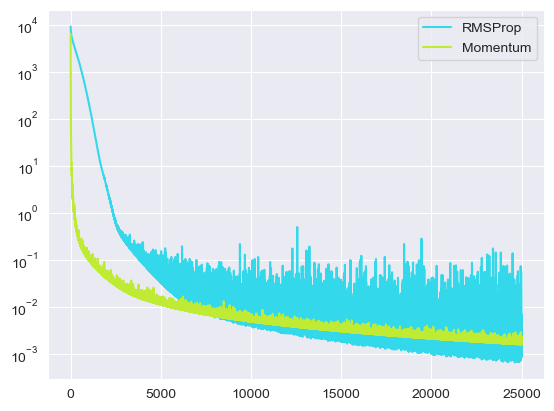

In [6]:
plt.yscale('log')
plt.plot(mse1, color='#34d8eb', label='RMSProp')
plt.plot(mse2, color='#c0eb34', label='Momentum')
plt.legend()

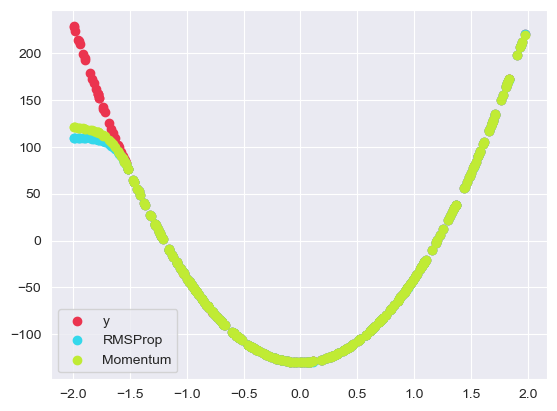

In [7]:
y1 = [N1.forward(ss_test['x'].values[i].reshape(1, 1))[0][0] for i in range(len(ss_test['x'].values))]
y2 = [N2.forward(ss_test['x'].values[i].reshape(1, 1))[0][0] for i in range(len(ss_test['x'].values))]
plt.scatter(ss_test['x'], ss_test['y'], color='#eb344f', label='y')
plt.scatter(ss_test['x'], y1, color='#34d8eb', label='RMSProp')
plt.scatter(ss_test['x'], y2, color='#c0eb34', label='Momentum')
plt.legend()

## Steps large

In [13]:
ss_train = pd.read_csv('NN\\regression\\steps-large-training.csv', dtype=np.longdouble)
ss_test = pd.read_csv('NN\\regression\\steps-large-test.csv', dtype=np.longdouble)
X = ss_train['x'].values.reshape(1, -1)
y = ss_train['y'].values.reshape(1, -1)
X_test = ss_test['x'].values.reshape(1, -1)
y_test = ss_test['y'].values.reshape(1, -1)

layers = [8, 8, 1]
fun_activation = [sigmoid for _ in range(len(layers) - 1)] + [linear]

params = {"eta": 0.1, "momentum": 0.9, "beta": 0.8, "epsilon": 10**(-8)}
N1 = RMSProp_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N1.train(X=X, Y=y, X_test=X_test, Y_test=y_test, epochs=5000, params=params, batch_size=64)
mse1 = N1.mse_list

params = {"eta": 0.01, "momentum": 0.5, "beta": 0.999, "epsilon": 10**(-8)}
N2 = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N2.train(X=X, Y=y, X_test=X_test, Y_test=y_test, epochs=5000, params=params, batch_size=64)
mse2 = N2.mse_list

print(f'MSE RMSProp = {mse1[-1]}, MSE2 Momentum = {mse2[-1]}')

Epoch 1/5000, MSE = 1873.3881, MSE test = 1873.3292
Epoch 101/5000, MSE = 56.7322, MSE test = 24.2968
Epoch 201/5000, MSE = 53.4101, MSE test = 69.2411
Epoch 301/5000, MSE = 37.9433, MSE test = 18.8717
Epoch 401/5000, MSE = 20.5334, MSE test = 18.4441
Epoch 501/5000, MSE = 27.3124, MSE test = 33.7064
Epoch 601/5000, MSE = 11.9647, MSE test = 3.6228
Epoch 701/5000, MSE = 30.1369, MSE test = 33.2431
Epoch 801/5000, MSE = 35.3371, MSE test = 28.9592
Epoch 901/5000, MSE = 14.0180, MSE test = 20.8688
Epoch 1001/5000, MSE = 26.9871, MSE test = 28.2132
Epoch 1101/5000, MSE = 21.2702, MSE test = 27.1270
Epoch 1201/5000, MSE = 20.4821, MSE test = 14.0162
Epoch 1301/5000, MSE = 28.8797, MSE test = 35.1863
Epoch 1401/5000, MSE = 30.4993, MSE test = 12.9450
Epoch 1501/5000, MSE = 31.7650, MSE test = 18.6970
Epoch 1601/5000, MSE = 29.3241, MSE test = 29.4500
Epoch 1701/5000, MSE = 31.7056, MSE test = 22.0028
Epoch 1801/5000, MSE = 31.3751, MSE test = 26.5540
Epoch 1901/5000, MSE = 25.6709, MSE test

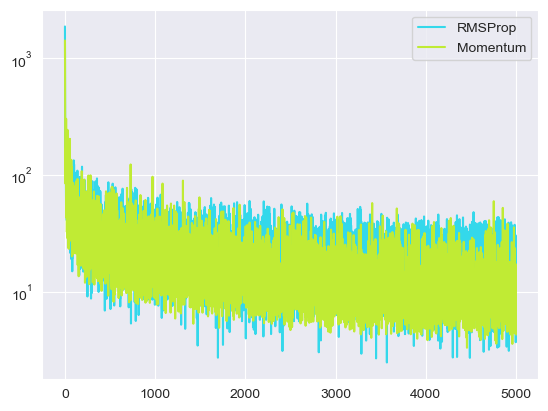

In [14]:
plt.yscale('log')
plt.plot(mse1, color='#34d8eb', label='RMSProp')
plt.plot(mse2, color='#c0eb34', label='Momentum')
plt.legend()

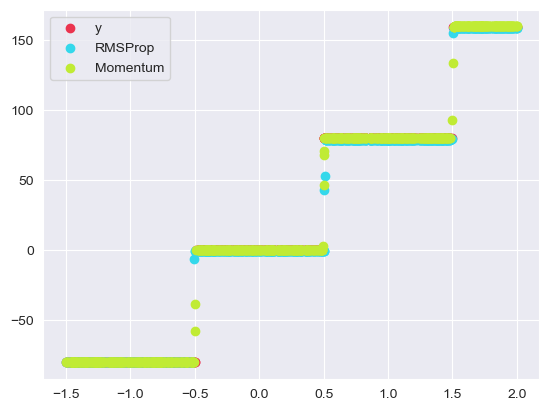

In [15]:
y1 = [N1.forward(ss_test['x'].values[i].reshape(1, 1))[0][0] for i in range(len(ss_test['x'].values))]
y2 = [N2.forward(ss_test['x'].values[i].reshape(1, 1))[0][0] for i in range(len(ss_test['x'].values))]
plt.scatter(ss_test['x'], ss_test['y'], color='#eb344f', label='y')
plt.scatter(ss_test['x'], y1, color='#34d8eb', label='RMSProp')
plt.scatter(ss_test['x'], y2, color='#c0eb34', label='Momentum')
plt.legend()

## Multimodal large

In [165]:
ml_train = pd.read_csv('NN\\regression\\multimodal-large-training.csv', dtype=np.longdouble)
ml_test = pd.read_csv('NN\\regression\\multimodal-large-test.csv', dtype=np.longdouble)
X = ml_train['x'].values.reshape(1, -1)
y = ml_train['y'].values.reshape(1, -1)
X_test = ml_test['x'].values.reshape(1, -1)
y_test = ml_test['y'].values.reshape(1, -1)

layers = [50, 1]
fun_activation = [sigmoid for _ in range(len(layers) - 1)] + [linear]

params = {"eta": 0.1, "momentum": 0.9, "beta": 0.99, "epsilon": 10**(-6)}
N1 = RMSProp_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N1.train(X=X, Y=y, X_test=X_test, Y_test=y_test, epochs=1000, params=params, batch_size=32)
mse1 = N1.mse_list

params = {"eta": 0.001, "momentum": 0.8, "beta": 0.999, "epsilon": 10**(-8)}
N2 = Momentum_Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)
N2.train(X=X, Y=y, X_test=X_test, Y_test=y_test, epochs=1000, params=params, batch_size=32)
mse2 = N2.mse_list

print(f'MSE RMSProp = {mse1[-1]}, MSE2 Momentum = {mse2[-1]}')

Epoch 1/1000, MSE = 1302.9652, MSE test = 1346.6366
Epoch 101/1000, MSE = 8.1558, MSE test = 3.6586
Epoch 201/1000, MSE = 7.1618, MSE test = 3.1907
Epoch 301/1000, MSE = 6.5642, MSE test = 2.5494
Epoch 401/1000, MSE = 6.8047, MSE test = 4.8317
Epoch 501/1000, MSE = 6.7017, MSE test = 4.0206
Epoch 601/1000, MSE = 5.7781, MSE test = 2.4063
Epoch 701/1000, MSE = 6.7382, MSE test = 5.2948
Epoch 801/1000, MSE = 22.0263, MSE test = 20.1979
Epoch 901/1000, MSE = 27.9528, MSE test = 24.6649
Epoch 1/1000, MSE = 2848.2425, MSE test = 2888.4811
Epoch 101/1000, MSE = 28.1301, MSE test = 24.5572
Epoch 201/1000, MSE = 13.0287, MSE test = 7.9397
Epoch 301/1000, MSE = 9.2809, MSE test = 4.0768
Epoch 401/1000, MSE = 7.7693, MSE test = 2.7058
Epoch 501/1000, MSE = 7.0263, MSE test = 2.0302
Epoch 601/1000, MSE = 6.5592, MSE test = 1.8178
Epoch 701/1000, MSE = 6.1984, MSE test = 1.6391
Epoch 801/1000, MSE = 6.0020, MSE test = 1.6153
Epoch 901/1000, MSE = 5.8958, MSE test = 1.6855
MSE RMSProp = 7.763271385

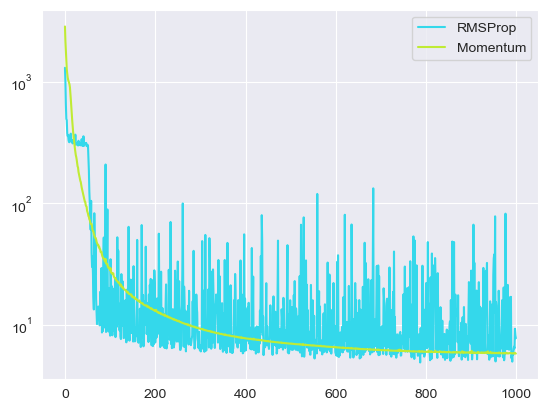

In [166]:
plt.yscale('log')
plt.plot(mse1, color='#34d8eb', label='RMSProp')
plt.plot(mse2, color='#c0eb34', label='Momentum')
plt.legend()

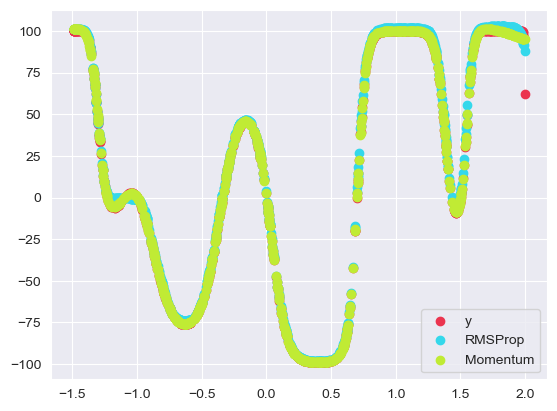

In [167]:
y1 = [N1.forward(ml_test['x'].values[i].reshape(1, 1))[0][0] for i in range(len(ml_test['x'].values))]
y2 = [N2.forward(ml_test['x'].values[i].reshape(1, 1))[0][0] for i in range(len(ml_test['x'].values))]
plt.scatter(ml_test['x'], ml_test['y'], color='#eb344f', label='y')
plt.scatter(ml_test['x'], y1, color='#34d8eb', label='RMSProp')
plt.scatter(ml_test['x'], y2, color='#c0eb34', label='Momentum')
plt.legend()